# SPamCo with Ensembles

In [1]:
#Math packages
import numpy as np

#Data packages
from sklearn.datasets import make_moons, make_classification, make_circles, make_blobs, make_gaussian_quantiles
from sklearn.model_selection import train_test_split

#Classifier packages
from sklearn.ensemble import RandomForestClassifier

#Validation packages
from sklearn.metrics import accuracy_score

#Visualization packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.ticker import MaxNLocator

#General utility packages
from itertools import cycle, islice
import warnings

warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 20})

## Utility functions for experiments

### Validation

validation() is designed to allow for both kfold cross validation collecting test accuracy for each fold. This function also implements random sampling and model testing that can run for n iterations and collect accuracy information. 

input:
1. pipeline: framework to be tested can be either a base classifier or SPamCo object
2. data: data to process with framework
3. cv: use cross-validation or random sampling
4. folds: number of folds to be used in cross-validation
5. iters: number of iterations for random sampling

output: 
1. list of accuracy values for each model training iteration



In [55]:
def validation(model_params, train_data_x, train_data_y, percent_labeled, random_seed, spaco=False, single_view=False, cv=False, folds=5, iters=100 ):
    
    metrics = []
    
    if cv:
        return metrics
    else:
        for step in range(iters):            
            if spaco:
                l_data = []
                u_data = []
                predictions = []

                x_train_val, x_test_val, y_train_val, y_test_val = train_test_split(
                    train_data_x, 
                    train_data_y, 
                    test_size=0.30,
                    stratify=train_data_y,
                    random_state=random_seed[step]
                )

                x_train, x_test, y_train, y_test = train_test_split(
                    x_train_val, 
                    y_train_val, 
                    test_size=1 - percent_labeled,
                    stratify=y_train_val,
                    random_state=random_seed[step]
                )
                if single_view:
                    l_data.append(x_train)
                    u_data.append(x_test)
                    
                    spaco = SPamCo(
                        labeled_data=l_data,
                        unlabeled_data=u_data,
                        labels=y_train,
                        num_view=model_params.get('num_view'),
                        gamma=model_params.get('gamma'),
                        iterations=model_params.get('steps'),
                        regularizer=model_params.get('regularizer')
                    )
                    
                    spaco.fit(model_params('classifier'))
                    clfs = spaco.get_classifiers()
                    pred_y = clfs[0].predict(x_test_val)
                    accuracy = accuracy_score(pred_y, y_test_val)
                    metrics.append(accuracy)
                else:
                    for i in range(x_train.shape[1]):
                        l_data.append(x_train[:,i].reshape(-1,1))
                        u_data.append(x_test[:,i].reshape(-1,1))
                        
                    spaco = SPamCo(
                        labeled_data=l_data,
                        unlabeled_data=u_data,
                        labels=y_train,
                        num_view=x_train.shape[1],
                        gamma=model_params.get('gamma'),
                        iterations=model_params.get('steps'),
                        regularizer=model_params.get('regularizer')
                    )
                    spaco.fit(model_params.get('classifier'))
                    clfs = spaco.get_classifiers()
                    
                    for view in range(len(clfs)):
                        pred = clfs[view].predict_proba(x_test_val[:,view].reshape(-1,1))
                        predictions.append(pred)
                    
                    pred_y = np.argmax(sum(predictions), axis = 1)
                    accuracy = accuracy_score(pred_y, y_test_val)
                    metrics.append(accuracy)
            else:

                x_train, x_test, y_train, y_test = train_test_split(
                    train_data_x, 
                    train_data_y, 
                    test_size=0.30,
                    stratify=train_data_y,
                    random_state=random_seed[step]
                )
                
                clf = model_params.get('classifier')
                clf.fit(x_train, y_train)

                clf_pred = clf.predict(x_test)
                metrics.append(accuracy_score(clf_pred, y_test))
    
    return metrics  

In [73]:
X1, Y1 = make_classification(
    n_features=4, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3
)
model =  {
    'classifier':RandomForestClassifier(),
    'num_view':1,
    'gamma':0.3,
    'steps':100,
    'regularizer':'hard'
}

metrics = validation(
    model_params=model,
    train_data_x=X1,
    train_data_y=Y1,
    percent_labeled=0.9,
    random_seed=np.arange(0,100)
)


In [74]:
np.mean(metrics)

0.7976666666666666

In [75]:
np.std(metrics)

0.06364048327213671

In [56]:
X1, Y1 = make_classification(
    n_features=4, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3
)

model =  {
    'classifier':RandomForestClassifier(),
    'num_view':1,
    'gamma':0.3,
    'steps':100,
    'regularizer':'hard'
}

metrics = validation(
    model_params=model,
    train_data_x=X1,
    train_data_y=Y1,
    percent_labeled=0.9,
    random_seed=np.arange(0,100),
    spaco=True
)

In [57]:
np.mean(metrics)

0.45133333333333325

In [58]:
np.std(metrics)

0.07140183626645902

In [59]:
X1, Y1 = make_classification(
    n_features=4, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3
)

model =  {
    'classifier':RandomForestClassifier(),
    'num_view':1,
    'gamma':0.3,
    'steps':100,
    'regularizer':'hard'
}

metrics = validation(
    model_params=model,
    train_data_x=X1,
    train_data_y=Y1,
    percent_labeled=0.9,
    random_seed=np.arange(0,100),
    single_view=True
)

In [61]:
np.mean(metrics)

0.9473333333333335

In [62]:
np.std(metrics)

0.028354893757515647

### Generate data for toy experiments

Generates data for the Binary Classification toy experiment 

Data is generated from two gaussians with separate centers 

In [54]:
from dataclasses import dataclass, field
from typing import List
import numpy as np


@dataclass
class SPamCo:
    # initiate classifier
    clfs: list = field(default_factory=list)
    labeled_data: list = field(default=list)
    unlabeled_data: list = field(default_factory=list)
    labels: list = field(default_factory=list)
    num_view: int = 2
    gamma: float = 0.3
    regularizer: str = 'hard'
    iterations: float = 10
    add_num: int = 6
    update_add_num: int = 6
    sel_ids: list = field(default_factory=list)
    weights: list = field(default_factory=list)
    scores: list = field(default_factory=list) 
        
    def __str__(self):
        #todo: Print a clean representation of the perceptron
        print(f'Weights:\t{self.weights}')
        print(f'Classifiers:\t{self.clfs}')
        print(f'Scores:\t{self.scores}')
        print(f'num_view:\t{self.num_view}')
        print(f'Gamma:\t{self.gamma}')
        print(f'Labels:\t{self.labels}')

    def get_classifiers(self):
        return self.clfs
   
    def update_train(self, view, pred_y):
        add_ids = np.where(np.array(self.sel_ids[view]) != 0)[0]
        add_data = [d[add_ids] for d in self.unlabeled_data]
        new_train_data = [np.concatenate([d1, d2]) for d1,d2 in zip(self.labeled_data, add_data)]
        add_y = pred_y[add_ids]
        new_train_y = np.concatenate([self.labels, add_y])
        return new_train_data, new_train_y

    def get_lambda_class(self, view, pred_y):
        y = self.labels
        lambdas = np.zeros(self.scores[view].shape[1])
        add_ids = np.zeros(self.scores[view].shape[0])
        clss = np.unique(y)
        assert self.scores[view].shape[1] == len(clss)
        ratio_per_class = [sum(y == c)/len(y) for c in clss]
        for cls in range(len(clss)):
            indices = np.where(pred_y == cls)[0]
            if len(indices) == 0:
                continue
            cls_score = self.scores[view][indices, cls]
            idx_sort = np.argsort(cls_score)
            add_num = min(int(np.ceil(ratio_per_class[cls] * self.add_num)),
                          indices.shape[0])
            add_ids[indices[idx_sort[-add_num:]]] = 1
            lambdas[cls] = cls_score[idx_sort[-add_num]] - 0.1
        return add_ids.astype('bool'), lambdas

    def get_ids_weights(self, view, pred_y):
        '''
        pred_prob: predicted probability of all views on untrain data
        pred_y: predicted label for untrain data
        train_data: training data
        max_add: number of selected data
        gamma: view correlation hyper-parameter
        '''
        #print('Getting Lambdas')
        add_ids, lambdas = self.get_lambda_class(view, pred_y)

        #print('Getting Weights')
        weight = np.array([(self.scores[view][i, l] - lambdas[l]) / (self.gamma + 1e-5)
                           for i, l in enumerate(pred_y)],
                          dtype='float32')

        weight[~add_ids] = 0
        if self.regularizer == 'hard' or self.gamma == 0:
            weight[add_ids] = 1
            #print(f'Returning Weights {weight}')
            return add_ids, weight
        weight[weight < 0] = 0
        weight[weight > 1] = 1
        #print(f'Returning Weights {weight}')
        return add_ids, weight

    def update_ids_weights(self, view, pred_y):
        num_view = len(self.scores)
        for v in range(num_view):
            if v == view:
                continue
            ov = self.sel_ids[v]
            self.scores[view][ov, pred_y[ov]] += self.gamma * self.weights[v][ov] / (num_view-1)
        sel_id, weight = self.get_ids_weights(view, pred_y)
        return sel_id, weight
    
    def fit(self, classifier):
        
        #print('Intiating first classifiers and predictions')
        for view in range(self.num_view):
            self.clfs.append(classifier)
            self.clfs[view].fit(self.labeled_data[view], self.labels)
            self.scores.append(self.clfs[view].predict_proba(self.unlabeled_data[view]))
  
            pred_y = np.argmax(sum(self.scores), axis = 1)

        # initiate weights for unlabled examples
        #print('Initiating weights for unlabeled examples')
        for view in range(self.num_view):
            sel_id, weight = self.get_ids_weights(view, pred_y)
            
            self.sel_ids.append(sel_id)
            self.weights.append(weight)

        #print(f'Running {self.iterations} steps')
        pred_y = np.argmax(sum(self.scores), axis = 1)
        for step in range(self.iterations):
            for view in range(self.num_view):

                # Update Training data
                self.sel_ids[view], self.weights[view] = self.update_ids_weights(
                    view,
                    pred_y
                )
                new_labeled_data, new_labels = self.update_train(view, pred_y)

                # Update parameters
                self.clfs[view].fit(new_labeled_data[view], new_labels)
                self.scores[view] = self.clfs[view].predict_proba(self.unlabeled_data[view])
                
                # Update predictions
                pred_y = np.argmax(sum(self.scores), axis = 1)

                # Update lambda
                self.add_num += self.update_add_num

                # Update Training data
                self.sel_ids[view], self.weights[view] = self.update_ids_weights(
                    view,
                    pred_y
                )

            if len(new_labeled_data[0]) >= len(self.unlabeled_data[0]): break

RFC accuracy with 10 labeled data 0.7


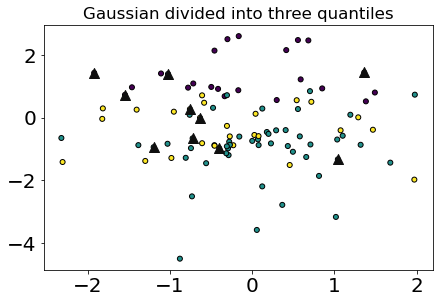

In [44]:
X1, Y1 = make_classification(
    n_features=4, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3
)
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.90, stratify = Y1, random_state=42)
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_pred = rfc.predict(X1)
print(f'RFC accuracy with {len(x_train)} labeled data {accuracy_score(rfc_pred, Y1)}')

plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=rfc_pred, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()

Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 20 steps
SPAMCO accuracy with (gamma=0.3) 10 labeled data 0.74


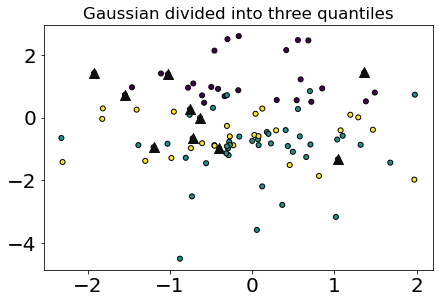

In [46]:
#### spaco experiment2 gamma=0.3
### parameters
steps = 20
gamma = .3

ldata = [
    x_train
    ]
udata = [
    x_test
    ]

spaco = SPamCo(
    labeled_data=ldata,
    unlabeled_data=udata,
    labels=y_train,
    num_view=1,
    gamma=0.3,
    iterations=steps
)

spaco.fit(RandomForestClassifier())
clfs = spaco.get_classifiers()
pred_y = clfs[0].predict(X1)

print(f'SPAMCO accuracy with (gamma={gamma}) {len(x_train)} labeled data {accuracy_score(pred_y, Y1)}')
plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=pred_y, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()

Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 20 steps
SPAMCO accuracy with (gamma=0.3) 10 labeled data 0.39


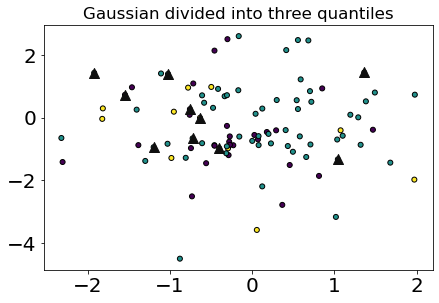

In [45]:
#### spaco experiment2 gamma=0.3
### parameters
steps = 20
gamma = .3

ldata = [
    x_train[:,0].reshape(-1,1),
    x_train[:,1].reshape(-1,1),
    x_train[:,2].reshape(-1,1),
    x_train[:,3].reshape(-1,1)
    ]
udata = [
    x_test[:,0].reshape(-1,1),
    x_test[:,1].reshape(-1,1),
    x_test[:,2].reshape(-1,1),
    x_test[:,3].reshape(-1,1)
    ]

spaco = SPamCo(
    labeled_data=ldata,
    unlabeled_data=udata,
    labels=y_train,
    num_view=4,
    gamma=0.3,
    iterations=steps
)

spaco.fit(RandomForestClassifier())
clfs = spaco.get_classifiers()
score1 = clfs[0].predict_proba(X1[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X1[:,1].reshape(-1,1))
score3 = clfs[2].predict_proba(X1[:,2].reshape(-1,1))
score4 = clfs[3].predict_proba(X1[:,3].reshape(-1,1))
score = score1 + score2 + score3 +score4
pred_y = np.argmax(score, axis = 1)

print(f'SPAMCO accuracy with (gamma={gamma}) {len(x_train)} labeled data {accuracy_score(pred_y, Y1)}')
plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=pred_y, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()

In [84]:
###Generate data for Binary Classification
def get_data(random_seed):
    np.random.seed(random_seed) 
    X,y = make_blobs(n_samples=150, centers=2, cluster_std=0.7)
    X[:,0] -= 9.3
    X[:,1] -= 2.5

    np.random.seed(1)
    pos_ids = np.where(y == 0)[0]
    neg_ids = np.where(y == 1)[0]
    ids1 = np.random.randint(0,len(pos_ids),5)
    ids2 = np.random.randint(0,len(neg_ids),5)
    p1 = pos_ids[ids1]
    p2 = neg_ids[ids2]

    ## generate labeled and unlabeled data
    l_ids = np.concatenate((p1 , p2))
    u_ids = np.array(list(set(np.arange(X.shape[0])) - set(l_ids)))
    l_data1, l_data2 = X[l_ids,0].reshape(-1,1), X[l_ids,1].reshape(-1,1)
    u_data1, u_data2 = X[u_ids,0].reshape(-1,1), X[u_ids,1].reshape(-1,1)
    labels = y[l_ids]
    return [l_data1, l_data2], [u_data1, u_data2], labels, X, y, [p1, p2]


Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 25 steps
spaco experiment(gamma=3): 0.66667
Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 25 steps
spaco experiment(gamma=0.3): 0.90000


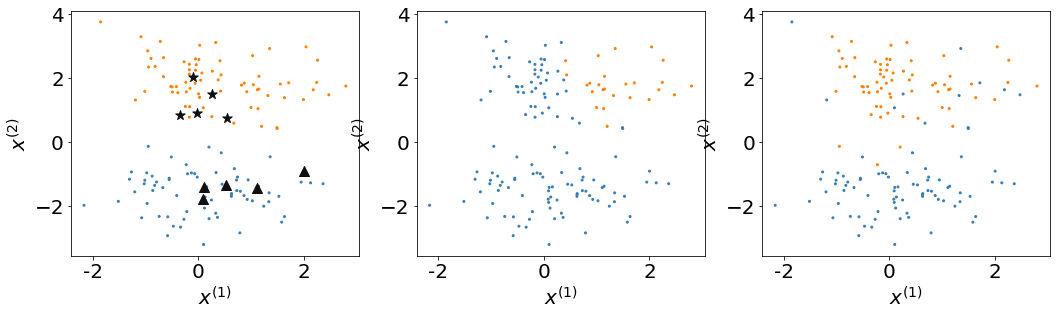

In [91]:

    
x = [-1.5,0,1.5]
my_xticks=[-2,0,2]

### Get data
ldata, udata, labels, X, y, label_ids = get_data(4)

### parameters
steps = 25
gamma = 3

### original fig
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y) + 3))))
fig = plt.figure(figsize=(16,4))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=0.9)

ax = fig.add_subplot(131)
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[y], s=4)
plt.scatter(X[label_ids[0],0], X[label_ids[0],1], marker='^', c='#0F0F0F', s=100)
plt.scatter(X[label_ids[1],0], X[label_ids[1],1], marker='*', c='#0F0F0F', s=100)
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.xticks(x, my_xticks)
     
    
#### spaco experiment1 gamma=3
spaco = SPamCo(
    labeled_data=ldata,
    unlabeled_data=udata,
    labels=labels,
    num_view=2,
    gamma=3,
    iterations=steps
)

spaco.fit(RandomForestClassifier())
clfs = spaco.get_classifiers()
score1 = clfs[0].predict_proba(X[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.argmax(score, axis = 1)
print('spaco experiment(gamma=3): %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(132)    
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)


#### spaco experiment2 gamma=0.3
spaco = SPamCo(
    labeled_data=ldata,
    unlabeled_data=udata,
    labels=labels,
    num_view=2,
    gamma=0.3,
    iterations=steps
)

spaco.fit(RandomForestClassifier())
clfs = spaco.get_classifiers()
score1 = clfs[0].predict_proba(X[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.argmax(score, axis = 1)
print('spaco experiment(gamma=0.3): %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(133)    
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)

plt.show() 

### SPamCo Framework

In [86]:
## SPamCo Framework
def update_train(sel_ids, train_data, train_labels, untrain_data, pred_y):
    add_ids = np.where(np.array(sel_ids) != 0)[0]
    add_data = [d[add_ids] for d in untrain_data]
    new_train_data = [np.concatenate([d1, d2]) for d1,d2 in zip(train_data, add_data)]
    add_y = pred_y[add_ids]
    new_train_y = np.concatenate([train_labels, pred_y[add_ids]])
    return new_train_data, new_train_y

def get_lambda_class(pred_prob, pred_y, y_train, max_add):
    y = y_train
    lambdas = np.zeros(pred_prob.shape[1])
    add_ids = np.zeros(pred_prob.shape[0])
    clss = np.unique(y)
    assert pred_prob.shape[1] == len(clss)
    ratio_per_class = [sum(y == c)/len(y) for c in clss]
    for cls in range(len(clss)):
        indices = np.where(pred_y == cls)[0]
        if len(indices) == 0:
            continue
        cls_score = pred_prob[indices, cls]
        idx_sort = np.argsort(cls_score)
        add_num = min(int(np.ceil(ratio_per_class[cls] * max_add)),
                      indices.shape[0])
        add_ids[indices[idx_sort[-add_num:]]] = 1
        lambdas[cls] = cls_score[idx_sort[-add_num]] - 0.1
    return add_ids.astype('bool'), lambdas

def get_ids_weights(pred_prob, pred_y, y_train, max_add, gamma, regularizer='hard'):
    '''
    pred_prob: predicted probability of all views on untrain data
    pred_y: predicted label for untrain data
    train_data: training data
    max_add: number of selected data
    gamma: view correlation hyper-parameter
    '''
    #print('Getting Lambdas')
    add_ids, lambdas = get_lambda_class(pred_prob, pred_y, y_train, max_add)

    #print('Getting Weights')
    weight = np.array([(pred_prob[i, l] - lambdas[l]) / (gamma + 1e-5)
                       for i, l in enumerate(pred_y)],
                      dtype='float32')
    weight[~add_ids] = 0
    if regularizer == 'hard' or gamma == 0:
        weight[add_ids] = 1
        #print(f'Returning Weights {weight}')
        return add_ids, weight
    weight[weight < 0] = 0
    weight[weight > 1] = 1
    #print(f'Returning Weights {weight}')
    return add_ids, weight

def update_ids_weights(view, probs, sel_ids, weights, pred_y, train_data,
                       max_add, gamma, regularizer='hard'):
    num_view = len(probs)
    for v in range(num_view):
        if v == view:
            continue
        ov = sel_ids[v]
        probs[view][ov, pred_y[ov]] += gamma * weights[v][ov] / (num_view-1)
    sel_id, weight = get_ids_weights(probs[view], pred_y, train_data,
                                     max_add, gamma, regularizer)
    return sel_id, weight

def spaco(l_data, lbls, u_data, iter_step = 1, gamma = 0.5, num_view=2, add_num= 6, regularizer='hard'):
    
    # initiate classifier
    clfs = []
    scores = []
    add_num = add_num
    update_add_num = add_num
    sel_ids = []
    weights = []

    print('Intiating first classifiers and predictions')
    for view in range(num_view):
        clfs.append(RandomForestClassifier())
        clfs[view].fit(l_data[view], lbls)
        scores.append(clfs[view].predict_proba(u_data[view]))
        #add_ids.append(sel_ids_y(scores[view], add_num))
        pred_y = np.argmax(sum(scores), axis = 1)
    
    # initiate weights for unlabled examples
    print('Initiating weights for unlabeled examples')
    for view in range(num_view):
        sel_id, weight = get_ids_weights(scores[view], pred_y,
                                            lbls, add_num, gamma,
                                            regularizer)
        sel_ids.append(sel_id)
        weights.append(weight)
    
    print(f'Running {iter_step} steps')
    pred_y = np.argmax(sum(scores), axis = 1)
    for step in range(iter_step):
        for view in range(2):
            
            # Update v
            sel_ids[view], weights[view] = update_ids_weights(
                view,
                scores,
                sel_ids,
                weights,
                pred_y,
                lbls,
                add_num,
                gamma,
                regularizer
            )
                             
            #update w
            nl_data, nlbls = update_train(sel_ids[view], l_data, lbls, u_data, pred_y)
            clfs[view].fit(nl_data[view], nlbls)
            scores[view] = clfs[view].predict_proba(u_data[view])
            pred_y = np.argmax(sum(scores), axis = 1)
            
            add_num += update_add_num

            sel_ids[view], weights[view] = update_ids_weights(
                view,
                scores,
                sel_ids,
                weights,
                pred_y,
                lbls,
                add_num,
                gamma,
                regularizer
            )
                     
            
        if len(nl_data[0]) >= len(u_data[0]): break
    return clfs

Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 16 steps
spaco experiment(gamma=3): 0.92667
Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 16 steps
spaco experiment(gamma=0.3): 0.82667


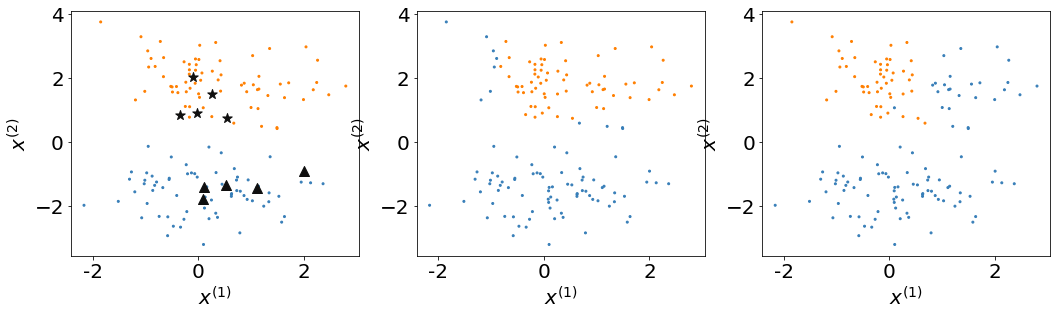

In [90]:
x = [-1.5,0,1.5]
my_xticks=[-2,0,2]

### Get data
ldata, udata, labels, X, y, label_ids = get_data(4)

### parameters
steps = 16
gamma = 3

### original fig
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y) + 3))))
fig = plt.figure(figsize=(16,4))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=0.9)

ax = fig.add_subplot(131)
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[y], s=4)
plt.scatter(X[label_ids[0],0], X[label_ids[0],1], marker='^', c='#0F0F0F', s=100)
plt.scatter(X[label_ids[1],0], X[label_ids[1],1], marker='*', c='#0F0F0F', s=100)
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.xticks(x, my_xticks)
     
    
#### spaco experiment1 gamma=3
clfs = spaco(ldata, labels, udata, iter_step=steps, gamma=3)
score1 = clfs[0].predict_proba(X[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.argmax(score, axis = 1)
print('spaco experiment(gamma=3): %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(132)    
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)


#### spaco experiment2 gamma=0.3
clfs = spaco(ldata, labels, udata, iter_step=steps, gamma=0.3, regularizer='soft')
score1 = clfs[0].predict_proba(X[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.argmax(score, axis = 1)
print('spaco experiment(gamma=0.3): %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(133)    
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)

plt.show()

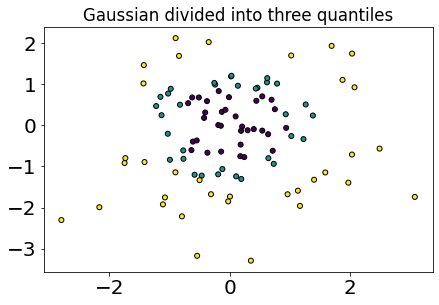

In [104]:
plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
X1, Y1 = make_gaussian_quantiles(n_features=2, n_classes=3)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

plt.show()

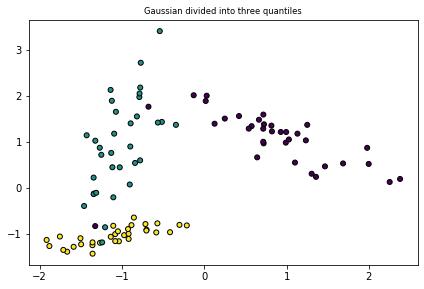

0.93

In [44]:
X1, Y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3
)

plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

plt.show()

x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.90, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_pred = rfc.predict(X1)
accuracy_score(rfc_pred, Y1)

RFC accuracy with 120 labeled data 0.9925


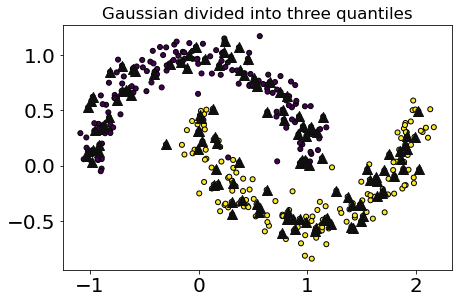

In [5]:
X1, Y1 = make_moons(
    n_samples=400,
    shuffle=True,
    noise=.1
)
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.70, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_pred = rfc.predict(X1)
print(f'RFC accuracy with {len(x_train)} labeled data {accuracy_score(rfc_pred, Y1)}')

plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=rfc_pred, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()

Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 20 steps
SPAMCO accuracy with (gamma=3) 120 labeled data 0.9275


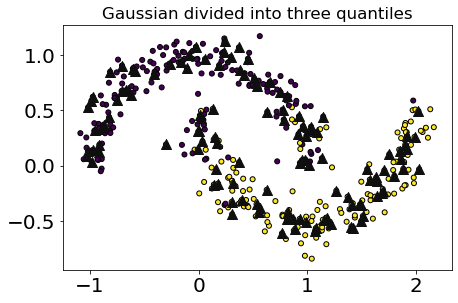

In [7]:
#### spaco experiment2 gamma=0.3
### parameters
steps = 20
gamma = 3

ldata = [
    x_train[:,0].reshape(-1,1),
    x_train[:,1].reshape(-1,1)
    ]
udata = [
    x_test[:,0].reshape(-1,1),
    x_test[:,1].reshape(-1,1)
    ]

clfs = spaco(ldata, y_train, udata, iter_step=steps, gamma=gamma, regularizer='soft')
score1 = clfs[0].predict_proba(X1[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X1[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.argmax(score, axis = 1)

print(f'SPAMCO accuracy with (gamma={gamma}) {len(x_train)} labeled data {accuracy_score(pred_y, Y1)}')
plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=pred_y, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()

RFC accuracy with 10 labeled data 0.59


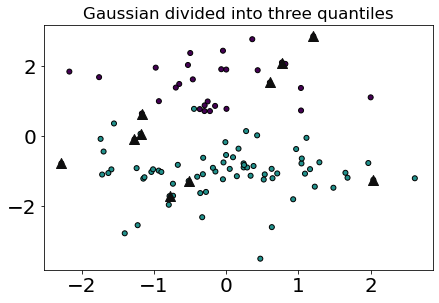

In [8]:
X1, Y1 = make_classification(
    n_features=4, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3
)
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.90, random_state=42)
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_pred = rfc.predict(X1)
print(f'RFC accuracy with {len(x_train)} labeled data {accuracy_score(rfc_pred, Y1)}')

plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=rfc_pred, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()

Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 20 steps
SPAMCO accuracy with (gamma=0.3) 10 labeled data 0.51


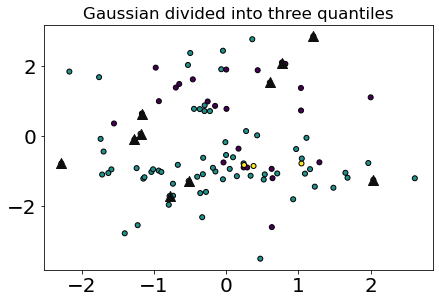

In [9]:
#### spaco experiment2 gamma=0.3
### parameters
steps = 20
gamma = .3

ldata = [
    x_train[:,0].reshape(-1,1),
    x_train[:,1].reshape(-1,1),
    x_train[:,2].reshape(-1,1),
    x_train[:,3].reshape(-1,1)
    ]
udata = [
    x_test[:,0].reshape(-1,1),
    x_test[:,1].reshape(-1,1),
    x_test[:,2].reshape(-1,1),
    x_test[:,3].reshape(-1,1)
    ]

clfs = spaco(ldata, y_train, udata, iter_step=steps, gamma=gamma, regularizer='soft', num_view=4)
score1 = clfs[0].predict_proba(X1[:,0].reshape(-1,1))
score2 = clfs[1].predict_proba(X1[:,1].reshape(-1,1))
score3 = clfs[2].predict_proba(X1[:,2].reshape(-1,1))
score4 = clfs[3].predict_proba(X1[:,3].reshape(-1,1))
score = score1 + score2 + score3 + score4
pred_y = np.argmax(score, axis = 1)

print(f'SPAMCO accuracy with (gamma={gamma}) {len(x_train)} labeled data {accuracy_score(pred_y, Y1)}')
plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=pred_y, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()

Intiating first classifiers and predictions
Initiating weights for unlabeled examples
Running 20 steps
SPAMCO accuracy with (gamma=0.3) 10 labeled data 0.61


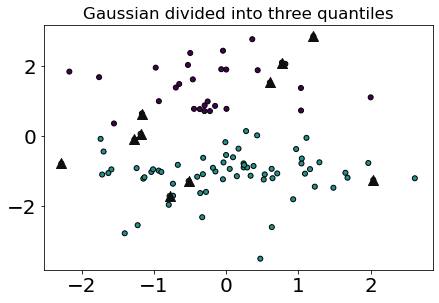

In [11]:
#### spaco experiment2 gamma=0.3
### parameters
steps = 20
gamma = .3

ldata = [
    x_train,
    x_train
    ]
udata = [
    x_test,
    x_test
    ]

clfs = spaco(ldata, y_train, udata, iter_step=steps, gamma=gamma, regularizer='soft', num_view=2)
pred_y = clfs[0].predict(X1)

print(f'SPAMCO accuracy with (gamma={gamma}) {len(x_train)} labeled data {accuracy_score(pred_y, Y1)}')
plt.figure()
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.title("Gaussian divided into three quantiles", fontsize="small")
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=pred_y, s=25, edgecolor="k")
plt.scatter(x_train[:, 0], x_train[:, 1], marker='^', c='#0F0F0F', s=100)

plt.show()